In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

import sys
import torch
import os, pickle
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import contextily as cx
import sklearn
from census import Census
import sys, os
import numpy as np

root = '/mnt/e/julia/regional-representations-graph-model/'
sys.path.append(root + 'dataset/safegraph/')
sys.path.append(root + 'train/')
sys.path.append(root + 'utils/')
sys.path.append(root + 'train_cnn_on_remote_sensing')
from resnet_class import RSResNet18

from models import *
from dataset_classes import*
from helper_funcs import *
import umap
# import hdbscan
import hdbscan
from sklearn.decomposition import PCA
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

scenario = 'all_valid_data/'
node_list_scenario = 'all_valid_data/'
savedir=root +  f'train/outputs/{scenario}evaluate/'
if not os.path.exists(savedir):
    createCleanDir(savedir)

# read in embeddings
node_list_path = root + f'dataset/preprocessed_data/{node_list_scenario}node_list.csv'
node_list = pd.read_csv(node_list_path, dtype={'GEOID': str})
num_nodes = node_list.shape[0]
idx_node_map = dict(zip(node_list.index, node_list['GEOID']))
node_idx_map = dict(zip(node_list['GEOID'], node_list.index))

# search = root + f'train/outputs/{scenario}landsat/'
# if os.path.exists(search):
#     for f in os.listdir(search):
#         if 'last.tar' in f:
#             pre_trained = search + f
#             break
            

# checkpoint=torch.load(pre_trained)
# model = NodeEmbeddings(num_nodes, embedding_dim=200)
# model.load_state_dict(checkpoint['model_state_dict'],strict=False)

In [32]:
def get_resnet_embedding(geoid):
    idx = node_list.loc[node_list['GEOID'] == geoid].index.values[0]
    return datasets1.__getsampleembeddingtest__(idx)

# Plot tracts

In [66]:
#      Read in Tract shapefiles
tract_data_dir = root + 'dataset/Tracts/nyc_metro_boundaries/nyc_metro_boundaries.shp'
geodf = gpd.read_file(tract_data_dir)
geodf.rename(columns={'GEOID_TRAC': 'GEOID'}, inplace=True)  
geodf = geodf[['GEOID', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'geometry']] 
def plot_list_geoids(geoid=None, df=None, col=None, cmap='Spectral', axes=None):
    if geoid is None:
        df_select = geodf
    else:
        df_select = geodf.loc[geodf.GEOID.isin(geoid)]
    
    if col == None:
        ax = df_select.plot(figsize=(10,8))
    else:
        temp = df_select.merge(df[['GEOID', col]], on='GEOID', how='left')
        if axes is not None:
            ax = temp.plot(column=col, legend=True, figsize=(10,8), cmap=cmap, ax=axes) #  palette=plt.colormaps['GnBu']
        else:
            ax = temp.plot(column=col, legend=True, figsize=(10,8), cmap=cmap)
            
    cx.add_basemap(ax, crs=df_select.crs.to_string())
    plt.title(f'{scenario} - {col}')
    return ax
    # minx, miny, maxx, maxy = df_select.total_bounds
    # ax.set_xlim(minx, maxx)
    # ax.set_ylim(miny, maxy)

NameError: name 'scenario' is not defined

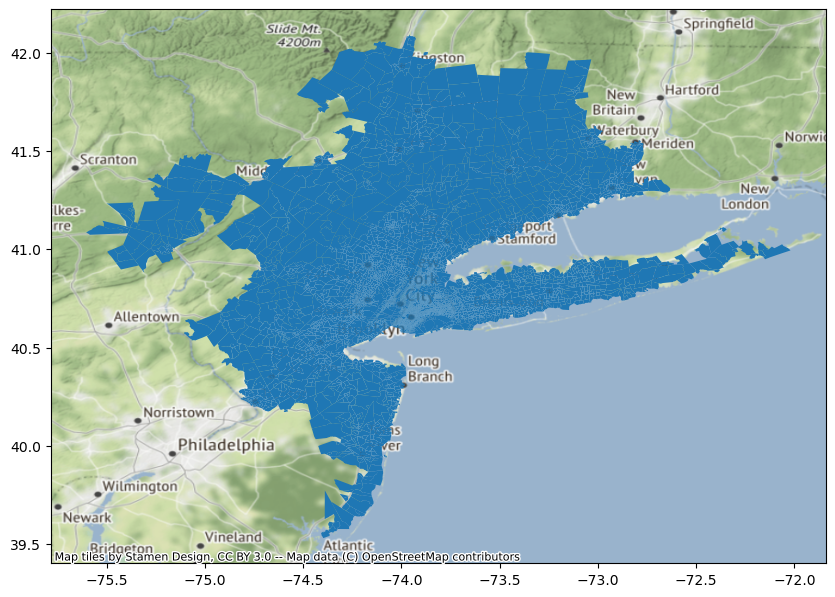

In [3]:
plot_list_geoids()

# Visualize Embeddings

Get census attributes per tract.

In [16]:
from census import Census

with open(root + 'dataset/api_keys/census_key.txt', 'r') as f:
    key = f.readline()
c = Census(key)

state_fps = ['42', '34', '36','25']

var = ['NAME', 'B01001_001E', 'B01001_026E', 'B01001_002E', 'B02001_003E', 'B02001_004E', 'B02001_005E', 'B02001_006E', 'B02001_007E', 
        'B01001H_001E', 'B01001I_001E', 'B01002_001E', 'B19013_001E', 'B19083_001E', 'B27001_001E', 
        'B08101_009E', 'B08101_017E', 'B08101_025E', 'B08101_033E', 'B08101_049E', 'B15003_017E',
           'B15003_022E', 'B15003_023E', 'B15003_025E']

name = ['NAME', 'total_pop',  'num_women', 'num_men', 'total_black', 'total_na', 'total_asian', 'total_paisl', 
        'total_other', 'total_white', 'total_latino', 'total_median_age', 'median_household_income', 
        'income_gini_index', 'health_insurance_coverage', 'num_drive_alone', 
        'num_carpool', 'num_public_transit', 'num_walk', 'num_wfh', 'hs_diploma', 
                      'bachelors_degree', 'masters_degree', 'doctorate_degree']

name_compute_ratio = ['num_women', 'num_men', 'total_black', 'total_na', 'total_asian', 'total_paisl', 'total_other', 'total_white', 'total_latino', 'health_insurance_coverage', 
                      'num_drive_alone', 'num_carpool', 'num_public_transit', 'num_walk', 'num_wfh', 'hs_diploma', 
                      'bachelors_degree', 'masters_degree', 'doctorate_degree']

cols = name + ['state', 'county', 'tract']
census_df = pd.DataFrame(columns=cols)
for state in state_fps:
    census = c.acs5.state_county_tract(fields = var,
                                        state_fips = state,
                                        county_fips = '*',
                                        tract = "*",
                                        year = 2020)
    
    d = pd.DataFrame(census)
    d.rename(columns=dict(zip(var, name)), inplace=True)
    for col in name_compute_ratio:
        d[col] = d[col]/d['total_pop']
        
    # combine embeddings with labels
    d['GEOID'] = d['state'].astype(str) + d['county'].astype(str) + d['tract'].astype(str)
        
    census_df = pd.concat([census_df, d])

# UMAP Clustering

Select embeddings.

In [68]:
# Model Embeddings
# add GEOID column to embeddings df
df = pd.DataFrame(checkpoint['model_state_dict']['node_embeddings.weight'].cpu())
df['GEOID'] = [idx_node_map[i] for i in df.index]
df = df.merge(census_df.drop(columns=['NAME']), on='GEOID')


# ResNet Embeddings
device='cpu'
landsat_model = ResNetTransform(device)
earth_engine_filename = 'least_cloudy_m6_m10_rectangle_highres.tif'
fn = earth_engine_filename
datasets1 = SatelliteImageryDataset(node_list_path=node_list_path, 
                                    root_image_dir='../dataset/earth_engine/download_landsat_images', 
                                    fn=fn, is_train=True, transform=landsat_model, 
                                    load_embeddings=True, embedding_fn='resnet_finetuned.pt') #img_resnet_original.pt
resnet_embeddings = node_list.GEOID.apply(get_resnet_embedding)
resnet_embeddings = resnet_embeddings.apply(lambda x: np.array(x))
df = pd.DataFrame(np.array(resnet_embeddings.values.tolist()))
df['GEOID'] = node_list.GEOID
df = df.merge(census_df.drop(columns=['NAME']), on='GEOID')
df.head()

0         1         2         3         4         5         6  \
0  0.004119  0.005240  0.004678  0.007946  0.003478  0.004435  0.005397   
1  0.003055  0.003486  0.001461  0.008752  0.001936  0.001946  0.007403   
2  0.002839  0.003365  0.001408  0.008555  0.001965  0.001890  0.007745   
3  0.004068  0.004686  0.004321  0.008024  0.003335  0.004533  0.005227   
4  0.002863  0.003363  0.001316  0.008676  0.001880  0.001733  0.007863   

          7         8         9  ...  num_public_transit  num_walk   num_wfh  \
0  0.006488  0.004648  0.003036  ...            0.019409  0.043625  0.021011   
1  0.007403  0.001349  0.000867  ...            0.000000  0.009466  0.034466   
2  0.007699  0.001436  0.000848  ...            0.027770  0.002995  0.007623   
3  0.006655  0.004334  0.003305  ...            0.004398  0.008795  0.018030   
4  0.007397  0.001289  0.000784  ...            0.011535  0.000000  0.027457   

   hs_diploma  bachelors_degree  masters_degree  doctorate_degree  state  \
0    0.178241          0.077457        0.028312          0.008547     42   
1    0.156068          0.183738        0.116505          0.041019     42   
2    0.262184          0.117071        0.044922          0.000000     42   
3    0.210642          0.121372        0.082674          0.008355     42   
4    0.184565          0.132900        0.088546          0.010236     42   

   county   tract  
0     089  300700  
1     089  300201  
2     089  300101  
3     103  950103  
4     103  950606  

[5 rows x 227 columns]

In [69]:
# # create a single dataframe so viz is the same
# valid = df.copy()
# for a, col in enumerate(['median_household_income','income_gini_index', 'num_wfh', 'num_public_transit', 'hs_diploma', 
#                       'bachelors_degree', 'masters_degree', 'doctorate_degree', 'total_median_age', 
#                        'num_drive_alone']):
    
#     valid = valid.loc[valid[col] > 0]
# binned_geoid = pd.read_csv(root + 'dataset/earth_engine/landsat_resolution_binned_geoids.csv', dtype={'GEOID': str})
# valid = valid.merge(binned_geoid, on='GEOID')
# valid.head()

In [70]:
binned_geoid = pd.read_csv(root + 'dataset/earth_engine/landsat_resolution_binned_geoids.csv', dtype={'GEOID': str})
df = df.merge(binned_geoid, on='GEOID')
df.head()

0         1         2         3         4         5         6  \
0  0.004119  0.005240  0.004678  0.007946  0.003478  0.004435  0.005397   
1  0.003055  0.003486  0.001461  0.008752  0.001936  0.001946  0.007403   
2  0.002839  0.003365  0.001408  0.008555  0.001965  0.001890  0.007745   
3  0.004068  0.004686  0.004321  0.008024  0.003335  0.004533  0.005227   
4  0.002863  0.003363  0.001316  0.008676  0.001880  0.001733  0.007863   

          7         8         9  ...   num_wfh  hs_diploma  bachelors_degree  \
0  0.006488  0.004648  0.003036  ...  0.021011    0.178241          0.077457   
1  0.007403  0.001349  0.000867  ...  0.034466    0.156068          0.183738   
2  0.007699  0.001436  0.000848  ...  0.007623    0.262184          0.117071   
3  0.006655  0.004334  0.003305  ...  0.018030    0.210642          0.121372   
4  0.007397  0.001289  0.000784  ...  0.027457    0.184565          0.132900   

   masters_degree  doctorate_degree  state  county   tract  npixels  pixel_bin  
0        0.028312          0.008547     42     089  300700     6035          2  
1        0.116505          0.041019     42     089  300201   234143          3  
2        0.044922          0.000000     42     089  300101   180914          3  
3        0.082674          0.008355     42     103  950103     4307          2  
4        0.088546          0.010236     42     103  950606   256520          3  

[5 rows x 229 columns]

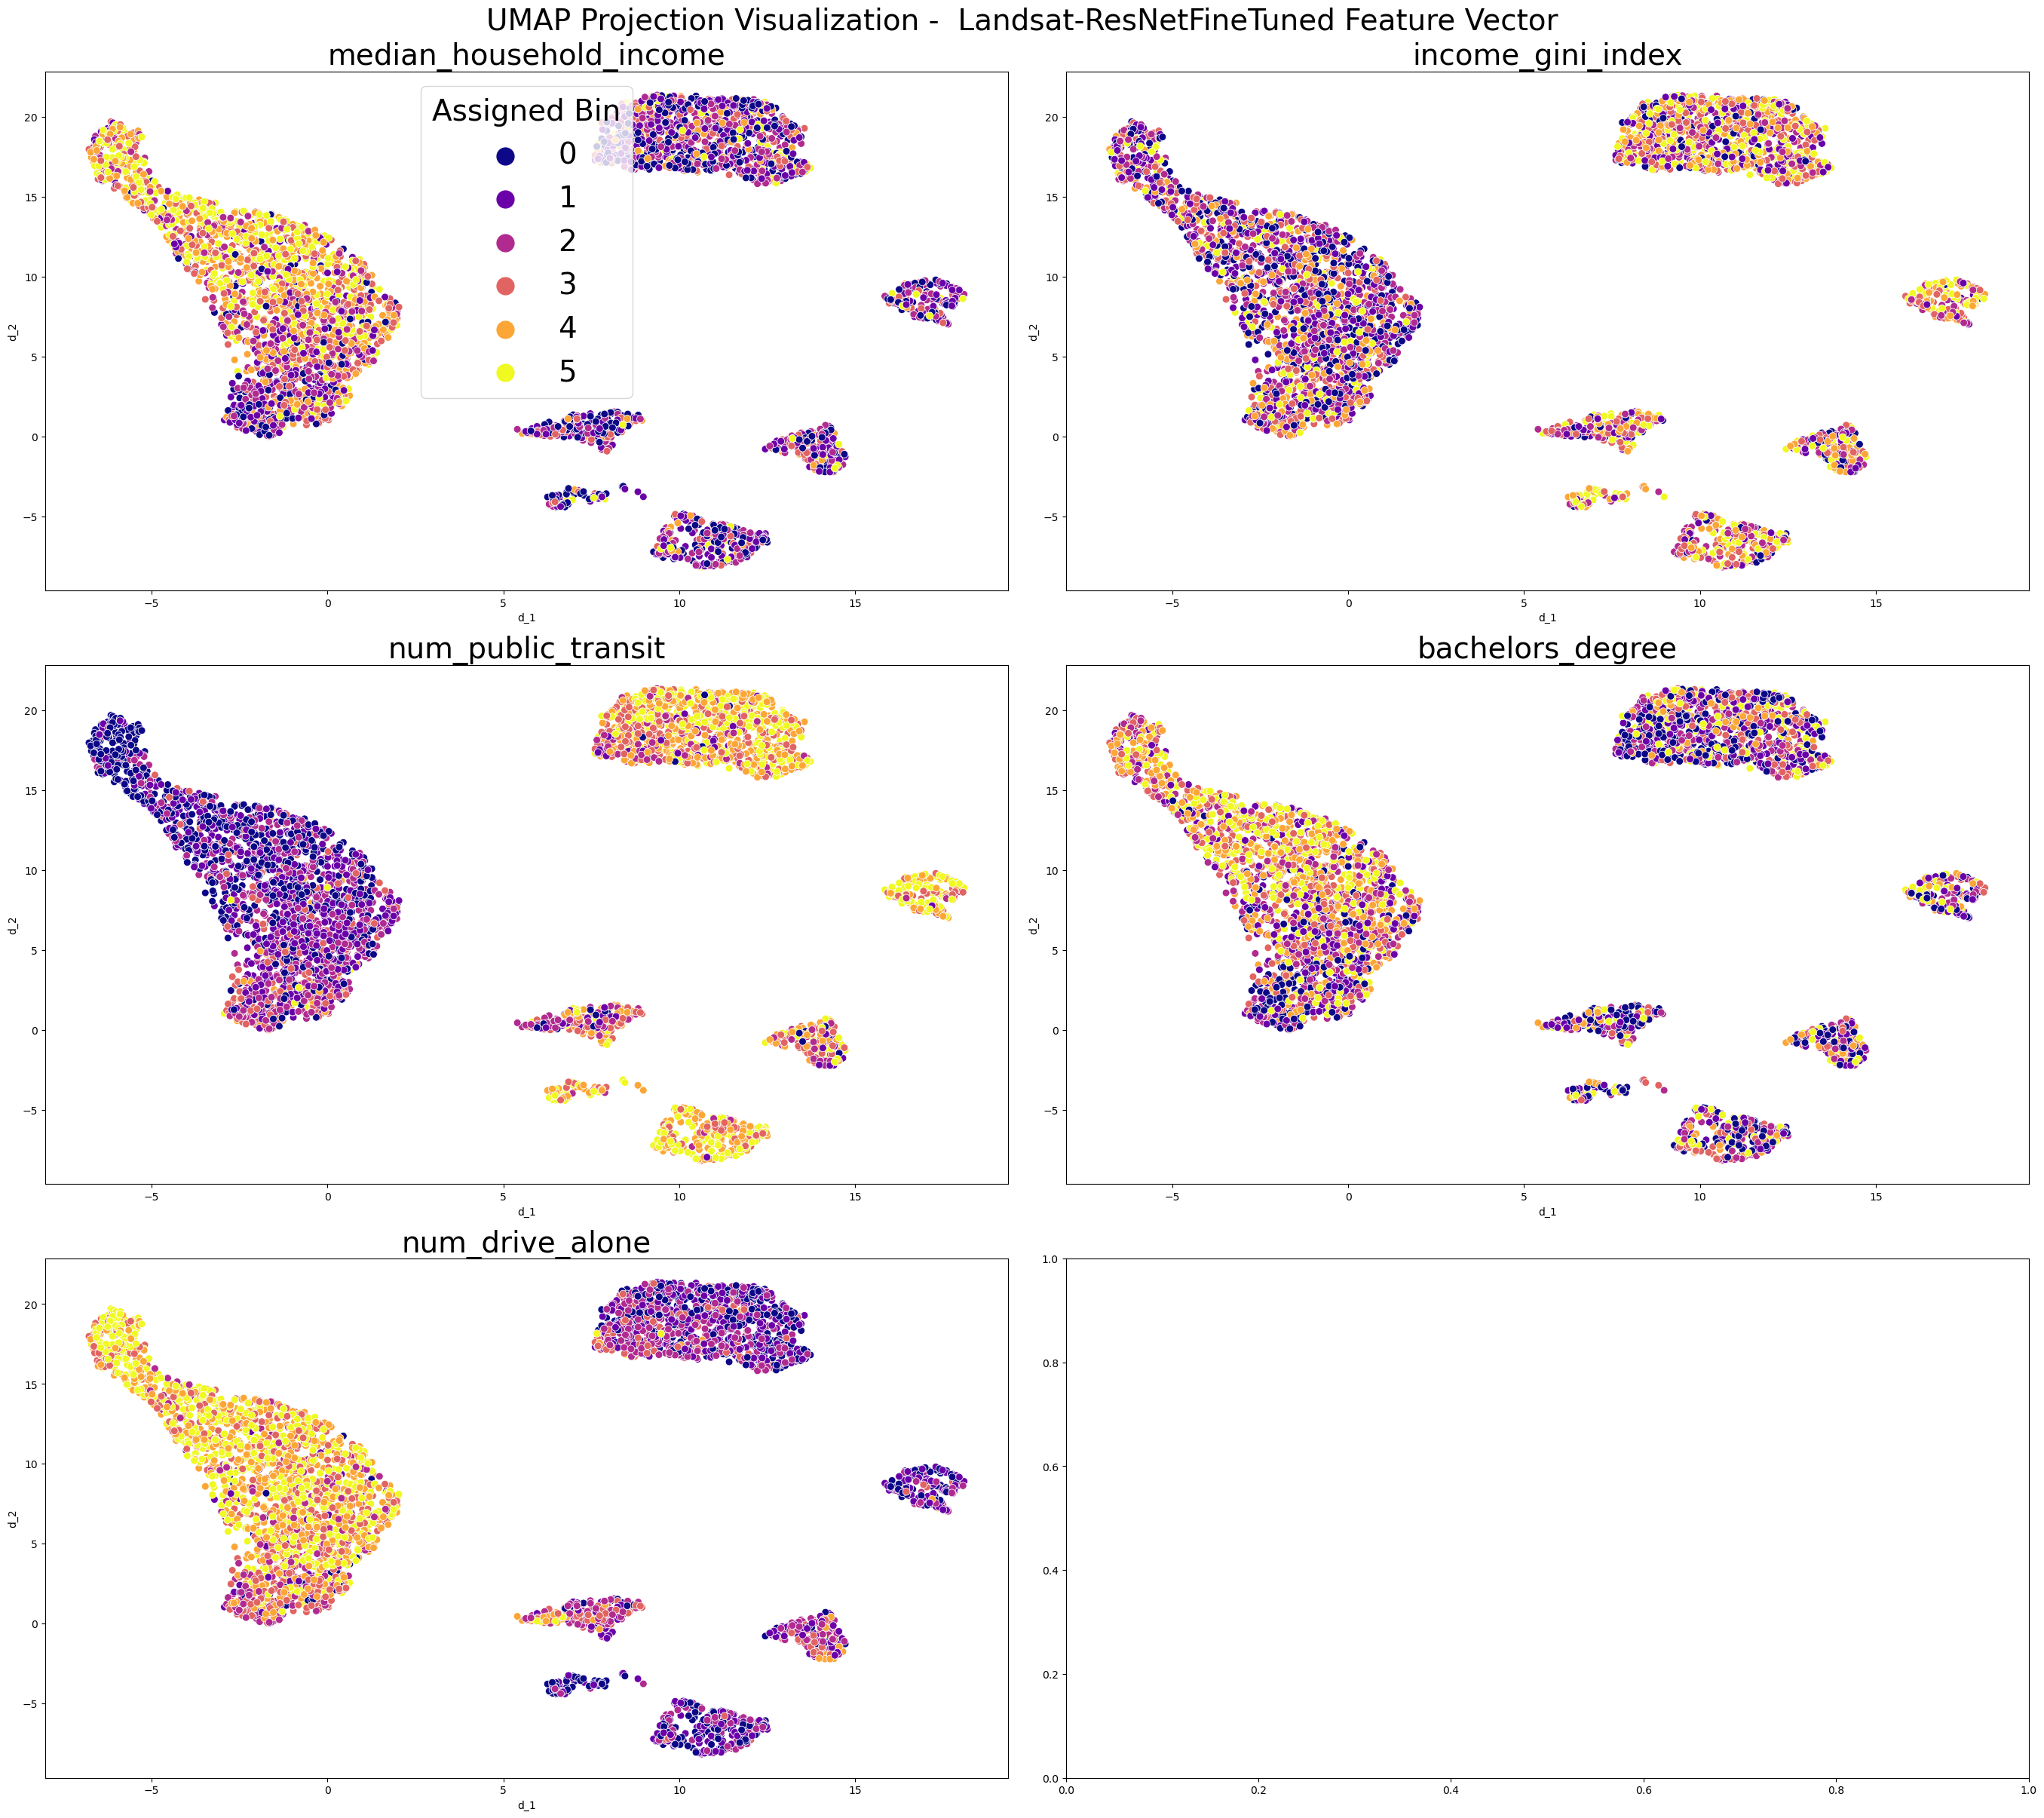

In [80]:
fig, ax = plt.subplots(3, 2, figsize=(27, 24), constrained_layout=True)
cols = ['median_household_income','income_gini_index',  'num_public_transit', 
                      'bachelors_degree', 'num_drive_alone']
reducer = umap.UMAP(n_neighbors=30, min_dist=0.5, n_components=2, metric='euclidean', random_state=42)
# reducer = PCA(n_components=2)
Y = reducer.fit_transform(df[[i for i in range(0, 200)]])
    
for a, col in enumerate(cols):
    
#     valid = df.loc[df[col] > 0]
    labs, bins = pd.qcut(df[col], 6, labels=False, retbins=True)
    y = labs
    
#     #Plot tract bins
#     valid[col+'_binned'] = labs
#     plot_list_geoids(valid['GEOID'], valid, col=col+'_binned')
#     plt.savefig(savedir + f'umap_{col}_tracts_by_bin')
    
#     plt.show()
    
    
#     # Plot col distribution
#     sns.violinplot(valid[col])
#     [plt.axhline(i, color='brown', alpha=0.5, ) for i in bins]
#     plt.title(f'{col}: BinSize~={int(bins[1]- bins[0])}')
#     plt.savefig(savedir + f'umap_{col}_distribution')
#     plt.show()
   

    result_df = pd.DataFrame({'d_1': Y[:,0], 'd_2': Y[:,1], col: y})

    #### For exploring UMAP params ####
    #                 axis = ax[j][i]
    #                 sns.scatterplot(x='d_1', y='d_2', hue=col, data=result_df, 
    #                                 ax=axis, palette=plt.colormaps['GnBu'])
    #                 axis.set_title(f'Neighbors={neighbors}, Metric={name}')
    #                 axis.axis("tight")

    #### For plotting all variables on same figure #####
    axis = ax.flatten()[a]
    sns.scatterplot(x='d_1', y='d_2', hue=col, data=result_df, 
                    ax=axis, palette=plt.colormaps['plasma'], s=50) #sns.cubehelix_palette(as_cmap=True)
    axis.set_title(f'{col}', fontsize=28)
    axis.axis("tight")
    handles, labels  =  axis.get_legend_handles_labels()
    
    if a == 0:
        l = axis.legend(title='Assigned Bin',
                  title_fontsize=28, fontsize=28)
        l.legend_handles[0]._sizes = [270] 
        l.legend_handles[1]._sizes = [270] 
        l.legend_handles[2]._sizes = [270] 
        l.legend_handles[3]._sizes = [270] 
        l.legend_handles[4]._sizes = [270] 
        l.legend_handles[5]._sizes = [270]
    else:
        axis.get_legend().remove()
#                 axis.set_facecolor('0.3')

#         plt.suptitle(f'{col}: n={valid.shape[0]}, MinDist={dist}', y=1.01)
#         plt.savefig(savedir + f'umap_{col}_{neighbors}neighbors', bbox_inches='tight')

#         plt.suptitle(f'UMAP Visualization - Metric: {name}, Neighbors: {neighbors}')
#         plt.savefig(savedir + f'umap_all_variables', bbox_inches='tight')

#         plt.show()


plt.suptitle(f'UMAP Projection Visualization -  Landsat-ResNetFineTuned Feature Vector', fontsize=28)
# plt.savefig(savedir + f'umap_all_variables', bbox_inches='tight')
plt.show()

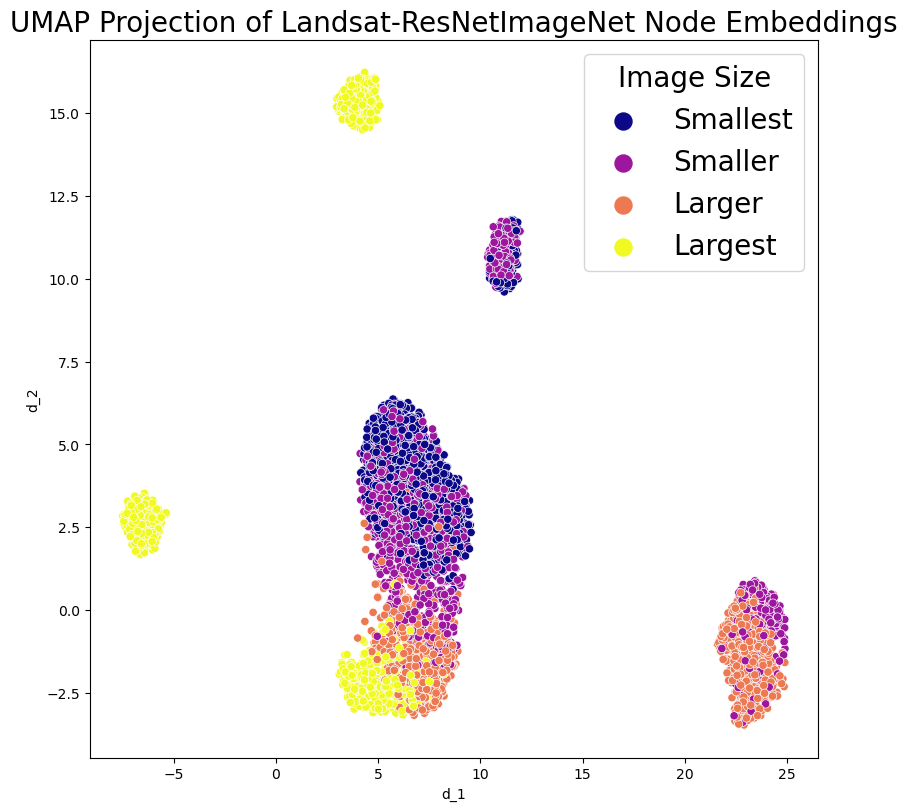

In [30]:
#### For plotting all variables on same figure #####
result_df = pd.DataFrame({'d_1': Y[:,0], 'd_2': Y[:,1], col: df['pixel_bin']})

fig, ax = plt.subplots(1, 1, figsize=(8, 8), constrained_layout=True)
sns.scatterplot(x='d_1', y='d_2', hue=col, data=result_df, 
                ax=ax, palette=plt.colormaps['plasma']) #'PiYG' 'Dark2' #plt.colormaps['plasma'], sns.cubehelix_palette(as_cmap=True)

ax.axis("tight")
plt.title('UMAP Projection of Landsat-ResNetImageNet Node Embeddings', fontsize=20)

handles, labels  =  ax.get_legend_handles_labels()
l = ax.legend(title='Image Size', handles=handles, labels=['Smallest', 'Smaller', 'Larger', 'Largest'],
         fontsize=20, title_fontsize=20)
l.legend_handles[0]._sizes = [150] 
l.legend_handles[1]._sizes = [150] 
l.legend_handles[2]._sizes = [150] 
l.legend_handles[3]._sizes = [150] 

# HDBSCAN
- Density-based clustering without assumption of uniform distributed clusters. Can create odd-shaped clusters.
- Good tutorial of clustering with UMAP: https://umap-learn.readthedocs.io/en/latest/clustering.html

Text(0.5, 1.0, 'UMAP Projection for Visualization')

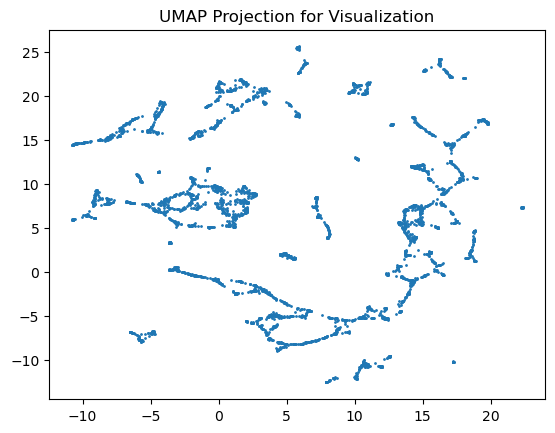

In [22]:
col = 'median_household_income'
valid = df#df.loc[df[col] > 0]

reducer = umap.UMAP(n_neighbors=30, min_dist=0.3, n_components=2, metric='euclidean', random_state=42)
umap_viz = reducer.fit_transform(valid[[i for i in range(0, 200)]])

plt.scatter(umap_viz[:, 0], umap_viz[:, 1],
            s=1);
plt.title('UMAP Projection for Visualization')

Below is the HDBSCAN labels overlayed on the PCA visualization.

In [23]:
lowd = PCA(n_components=50).fit_transform(valid[[i for i in range(0, 200)]])
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=100).fit_predict(lowd)
num_clusters = len(np.unique(hdbscan_labels)) - 1
(hdbscan_labels >= 0).sum()

pca_viz = PCA(n_components=2).fit_transform(valid[[i for i in range(0, 200)]])

Text(0.5, 1.0, '13 HDBSCAN Clusters on PCA displayed on PCA Projection')

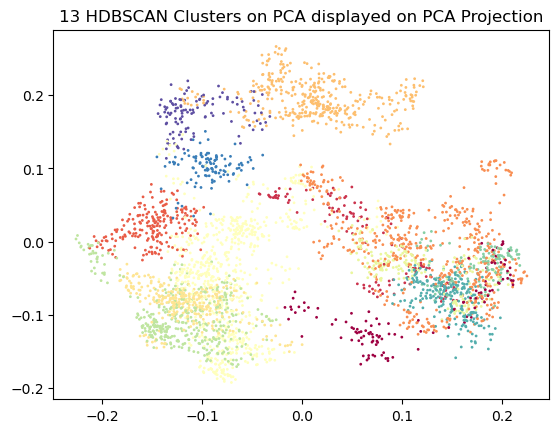

In [24]:
clustered = (hdbscan_labels >= 0)
# plt.figure(figsize=(8,8))
# plt.scatter(lowd[~clustered, 0],
#             lowd[~clustered, 1],
#             color=(0.5, 0.5, 0.5),
#             s=1,
#             alpha=0.5)
plt.scatter(pca_viz[clustered, 0],
            pca_viz[clustered, 1],
            c=hdbscan_labels[clustered],
            s=1,
            cmap='Spectral');

plt.title(f'{num_clusters} HDBSCAN Clusters on PCA displayed on PCA Projection')
# plt.savefig(root + f'train/outputs/{scenario}/clustering/HDBSCAN_Clusters_on_PCA_unstandardized')

Below is the HDBSCAN labels overlayed on the UMAP embedding visualization.

# Visualization of clusters vs geographic location

In [72]:
# d = np.array(df['ResNet'].tolist())  #valid[[i for i in range(0, 200)]]
d = df[[i for i in range(0, 200)]]

lowd = PCA(n_components=70).fit_transform(d)
hdbscan_labels = hdbscan.HDBSCAN(min_samples=4, min_cluster_size=100).fit_predict(lowd)
num_clusters = len(np.unique(hdbscan_labels)) - 1
(hdbscan_labels >= 0).sum()

3918

In [73]:
num_clusters = len(np.unique(hdbscan_labels)) - 1
num_clusters

6

In [74]:
reducer = umap.UMAP(n_neighbors=30, min_dist=0.3, n_components=2, metric='euclidean', random_state=42)
umap_viz = reducer.fit_transform(d)

In [75]:
# pca_viz = PCA(n_components=2).fit_transform(d)

In [87]:
plot_df

GEOID  Cluster
0     42089300700        2
1     42089300201        2
3     42103950103        2
8     42089301202        2
10    42089300600        2
...           ...      ...
4233  34017013800        3
4234  34017018800        4
4235  34017012300        1
4236  34017006200        1
4237  34017005500        1

[3918 rows x 2 columns]

In [91]:
geodf.total_bounds

array([-75.605348,  39.530397, -72.020157,  42.092592])

(40.530397, 40.992591999999995)

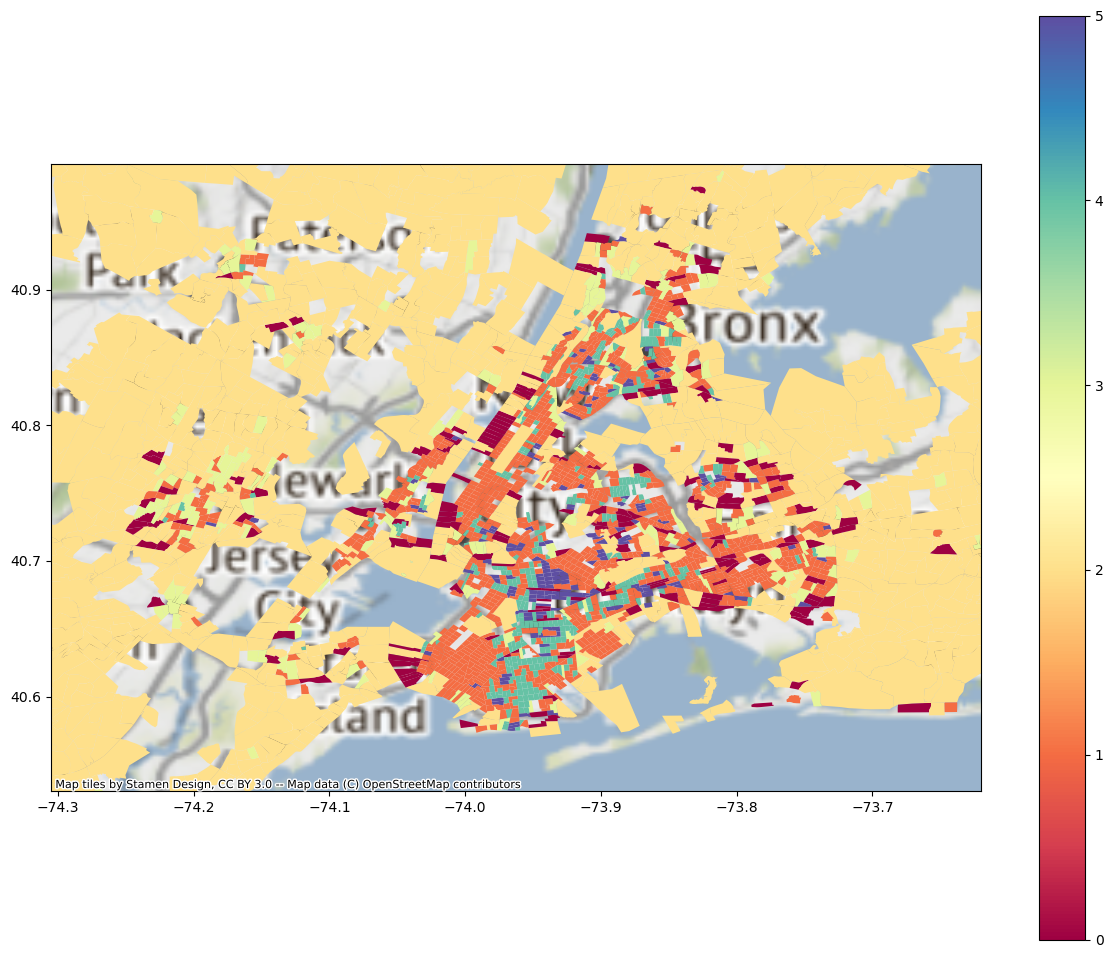

In [110]:
# plot map
plot_geo = pd.DataFrame(df.GEOID)#.copy() #valid['GEOID']
plot_geo['Cluster'] = hdbscan_labels

plot_df = plot_geo.loc[plot_geo.Cluster >= 0]

df_select = geodf
temp = df_select.merge(plot_df[['GEOID', 'Cluster']], on='GEOID', how='left')
ax = temp.plot(column='Cluster', legend=True, figsize=(15,12), cmap='Spectral')  
cx.add_basemap(ax, crs=df_select.crs.to_string())
 
minx, miny, maxx, maxy = geodf.total_bounds
ax.set_xlim(minx+1.3, maxx - 1.6)
ax.set_ylim(miny+1., maxy - 1.1)
# plot_list_geoids(geoid=list(plot_df['GEOID']), df=plot_df, col='Cluster', cmap='Spectral', axes=ax) #PiYG
# ax.set_title('Cluster Location')
# plt.suptitle(f'{num_clusters} HDBSCAN Clusters on PCA')

Text(0.5, 1.0, 'Outlier Location')

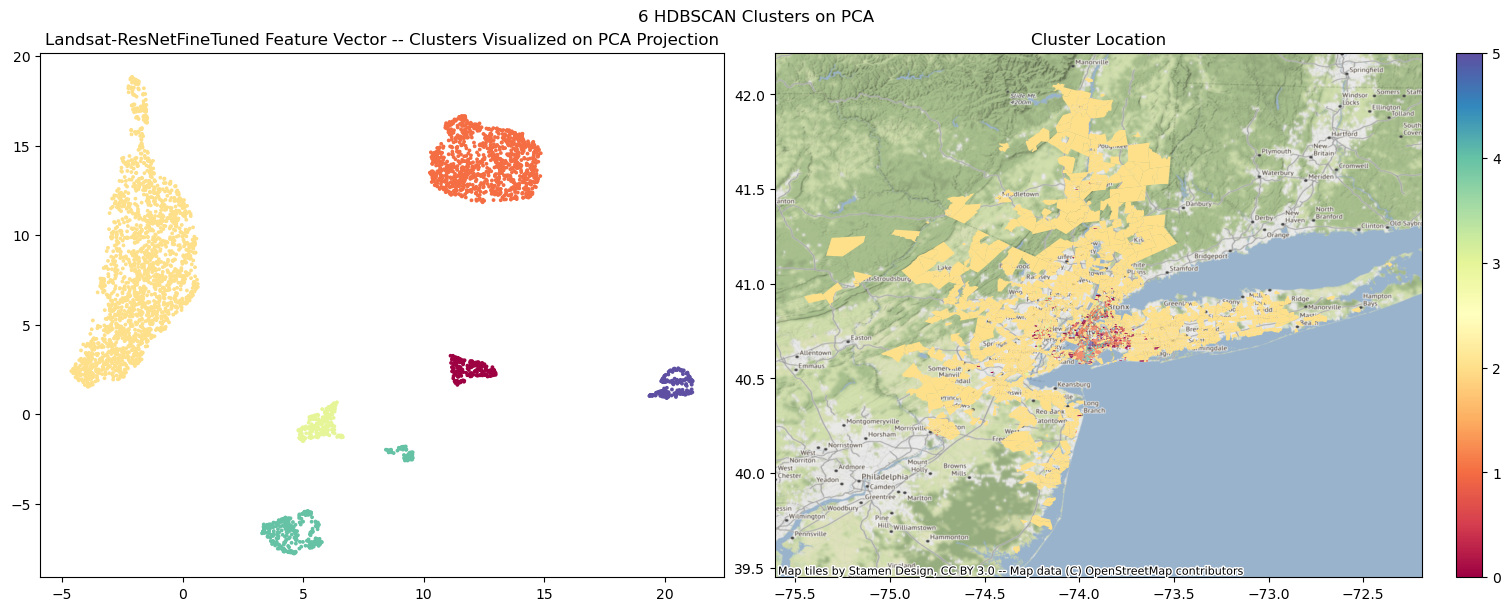

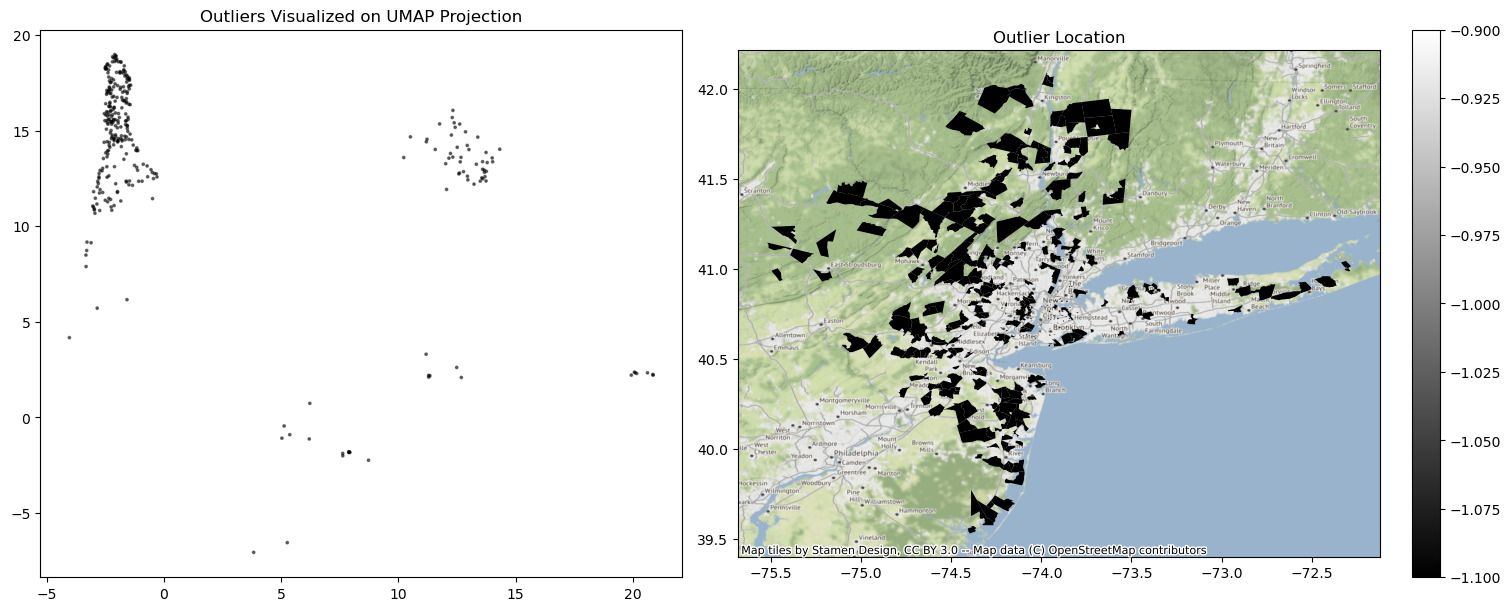

In [76]:
# umap_viz = pca_viz

clustered = (hdbscan_labels >= 0)

# plot clusters
fig, ax = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)
a = ax[0].scatter(umap_viz[clustered, 0],
            umap_viz[clustered, 1],
            c=hdbscan_labels[clustered],
            s=3,
            cmap='Spectral'); #'twilight'
num_clusters = len(np.unique(hdbscan_labels)) - 1
ax[0].set_title('Landsat-ResNetFineTuned Feature Vector -- Clusters Visualized on PCA Projection')

# plot map
plot_geo = pd.DataFrame(df.GEOID)#.copy() #valid['GEOID']
plot_geo['Cluster'] = hdbscan_labels

plot_df = plot_geo.loc[plot_geo.Cluster >= 0]
plot_list_geoids(geoid=list(plot_df['GEOID']), df=plot_df, col='Cluster', cmap='Spectral', axes=ax[1]) #PiYG
ax[1].set_title('Cluster Location')
plt.suptitle(f'{num_clusters} HDBSCAN Clusters on PCA')

# Outliers
fig, ax = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)
a = ax[0].scatter(umap_viz[~clustered, 0],
            umap_viz[~clustered, 1],
            c = hdbscan_labels[~clustered],
#             color=(0.5, 0.5, 0.5),
            s=3,
            alpha=0.5,
            cmap='gray')
num_clusters = len(np.unique(hdbscan_labels)) - 1
ax[0].set_title('Outliers Visualized on UMAP Projection')

# plot map
plot_df = plot_geo.loc[plot_geo.Cluster == -1]
a = plot_list_geoids(geoid=list(plot_df['GEOID']), df=plot_df, col='Cluster', cmap='gray', axes=ax[1])
ax[1].set_title('Outlier Location')

# plt.savefig(root + f'train/outputs/{scenario}/clustering/HDBSCAN_Clusters_on_PCA_unstandardized')

Now, we want to use UMAP for dimensionality reduction instead of for visualization.

In [32]:
reducer = umap.UMAP(n_neighbors=50, min_dist=0, n_components=50, metric='euclidean', random_state=42)
umap_clustering = reducer.fit_transform(valid[[i for i in range(0, 200)]])

In [33]:
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=100).fit_predict(umap_clustering)
(hdbscan_labels >= 0).sum()

3730

Text(0.5, 1.0, 'HDBSCAN Clusters on UMAP DR (17 clusters)')

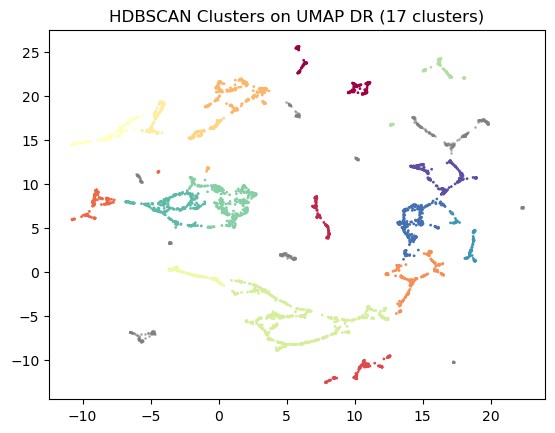

In [34]:
clustered = (hdbscan_labels >= 0)
# plt.figure(figsize=(8,8))
plt.scatter(umap_viz[~clustered, 0],
            umap_viz[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=1,
            alpha=0.5)
plt.scatter(umap_viz[clustered, 0],
            umap_viz[clustered, 1],
            c=hdbscan_labels[clustered],
            s=1,
            cmap='Spectral');

num_clusters = len(np.unique(hdbscan_labels)) - 1
plt.title(f'HDBSCAN Clusters on UMAP DR ({num_clusters} clusters)')
# plt.savefig(root + f'train/outputs/{scenario}/clustering/HDBSCAN_Clusters_on_UMAP_DR_unstandardized')

# Try with standardization

In [32]:
from sklearn import preprocessing
ss = preprocessing.StandardScaler()
scaled = ss.fit_transform(valid[[i for i in range(0, 200)]])

In [34]:
reducer = umap.UMAP(n_neighbors=50, min_dist=0, n_components=50, metric='euclidean', random_state=42)
umap_clustering = reducer.fit_transform(scaled)

In [35]:
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=50).fit_predict(umap_clustering)
(hdbscan_labels >= 0).sum()

3809

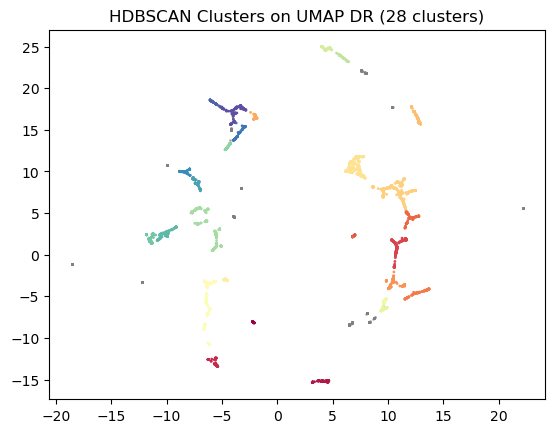

In [37]:
clustered = (hdbscan_labels >= 0)
# plt.figure(figsize=(8,8))
plt.scatter(umap_viz[~clustered, 0],
            umap_viz[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=1,
            alpha=0.5)
plt.scatter(umap_viz[clustered, 0],
            umap_viz[clustered, 1],
            c=hdbscan_labels[clustered],
            s=1,
            cmap='Spectral');

num_clusters = len(np.unique(hdbscan_labels)) - 1
plt.title(f'HDBSCAN Clusters on UMAP DR ({num_clusters} clusters)')
plt.savefig(root + f'train/outputs/{scenario}/clustering/HDBSCAN_Clusters_on_UMAP_DR_standardized')

In [23]:
# fig, ax = plt.subplots(11, 2, figsize=(30, 45), constrained_layout=True)

# for i, col in enumerate(['median_household_income', 'income_gini_index', 'num_wfh', 'num_public_transit', 'hs_diploma', 
#                       'bachelors_degree', 'masters_degree', 'doctorate_degree', 'total_median_age', 
#                          'health_insurance_coverage', 'num_drive_alone']):
    
    
#     valid = df.loc[df[col] > 0]
#     labs, bins = pd.cut(valid[col], 5, labels=False, retbins=True)
    
#     # n_clusters value 1
#     Y = cluster.KMeans(n_clusters=3).fit_predict(valid[[i for i in range(0, 200)]])
#     result_df = pd.DataFrame({'d_1': Y[:,0], 'd_2': Y[:,1], col: valid[col]})
#     sns.scatterplot(x='d_1', y='d_2', hue=col, data=result_df, 
#                     ax=ax[i][0], palette=plt.colormaps['GnBu'])
    
    
#     # n_clusters value 2
#     Y = cluster.KMeans(n_clusters=10).fit_predict(valid[[i for i in range(0, 200)]])
#     result_df = pd.DataFrame({'d_1': Y[:,0], 'd_2': Y[:,1], col: valid[col]})
#     sns.scatterplot(x='d_1', y='d_2', hue=col, data=result_df, 
#                     ax=ax[i][1], palette=plt.colormaps['GnBu'])

# Qualitative Analysis of Embedding Space

We expect to see closer tracts (in terms of distance or mobility) have representations closer in the embedding space. As distance increases, we expect the embeddings to be further.

If we observe this for both distance and mobility, this indicates that the model learned both spatial and mobility relationships.

In [35]:
from sklearn.metrics.pairwise import euclidean_distances
import random
from sklearn.decomposition import PCA
import umap
from scipy import stats
from sklearn import preprocessing
from math import perm
from math import comb
import itertools

In [58]:
scenario = 'mobility-distance/'
node_list_scenario = 'all_valid_data/'
path = f'/mnt/e/julia/regional-representations-graph-model/dataset/preprocessed_data/{node_list_scenario}'
device = 'cpu'
earth_engine_filename = 'least_cloudy_m6_m10_rectangle_highres.tif'
fn = earth_engine_filename

In [48]:
# Load distances
# #### DISTANCE #####
with open(path+'distance_node_idx_map.pkl', 'rb') as f:
    d1 = pickle.load(f)
with open(path+'distance_idx_node_map.pkl', 'rb') as f:
    d2 = pickle.load(f)
with open(path + 'distance_edge_matrix.pkl', 'rb') as f:
    data = pickle.load(f)
    
    
# landsat_model = ResNetTransform(device)
# datasets1 = SatelliteImageryDataset(node_list_path=node_list_path, 
#                                     root_image_dir='../dataset/earth_engine/download_landsat_images', 
#                                     fn=fn, is_train=True, transform=landsat_model, 
#                                     load_embeddings=True, embedding_fn='img_resnet_original.pt')


In [49]:
geoids = np.array(list(d1.keys()))
combos = list(itertools.combinations(geoids,2))

pca=PCA(n_components=2)
umap_reducer = umap.UMAP(n_neighbors=30, min_dist=0, n_components=2, metric='euclidean', random_state=42)
    
# sample x% of 10 million pairs of census tracts
k=15000
sampled_pairs = random.choices(combos, k=k)
percent = k/comb(num_nodes, 2)*100

In [50]:
# mobility data
graph_path = root + 'dataset/safegraph/graph_checkpoints/nyc_metro/checkpoint_norm.pkl'
with open(graph_path, 'rb') as f:
    g = pickle.load(f)

In [62]:
# load model embeddings
def get_model_weights(scenario=None, embedding_name=None):
    search = root + f'train/outputs/{scenario}{embedding_name}/'
    if os.path.exists(search):
        for f in os.listdir(search):
            if 'last.tar' in f:
                pre_trained = search + f
                break

    checkpoint=torch.load(pre_trained)

    # add GEOID column to embeddings df
    df = pd.DataFrame(checkpoint['model_state_dict']['node_embeddings.weight'].cpu())
    return df

In [63]:
print(f'Number of permutation pairs: {perm(num_nodes, 2)}')
print('M3G reports this number, for some reason...')

print(f'Number of unique pairs: {comb(num_nodes, 2)}')
print(f'1% is {comb(num_nodes, 2)*0.1}')
print(f'0.1% is {comb(num_nodes, 2)*0.01}')

Number of permutation pairs: 21146202
M3G reports this number, for some reason...
Number of unique pairs: 10573101
1% is 1057310.1
0.1% is 105731.01000000001


In [64]:
def get_model_embeddings_from_sampled(df, sampled_pairs):
    # get embeddings from model
    embeddings = np.array([(df.iloc[node_idx_map[pair[0]]], df.iloc[node_idx_map[pair[1]]]) for pair in sampled_pairs])
    return embeddings

# get spatial distance from matrix
def get_distance_from_sampled(d1, sampled_pairs):
    spatial_distance = [data[d1[pair[0]]][d1[pair[1]]]/1000 for pair in sampled_pairs]
    return spatial_distance

# or mobility
def get_mobility(g, a, b):
    return g.edge_mat[g.node_idx_map[a]][g.node_idx_map[b]]

def get_mobility_from_sampled(g, sampled_pairs):
    mobility_distance = [get_mobility(g, pair[0], pair[1]) + get_mobility(g, pair[1], pair[0]) for pair in sampled_pairs]
    return mobility_distance

def reduce_embedding_dimensions(embeddings):
    # list of all embeddings to fit dim reducer models
    e1 = embeddings[:, 0, :]
    e2 = embeddings[:, 1, :]

    # fit dim reducers to the data
    train = np.concatenate([e1, e2])
    pca.fit(train)
    umap_reducer.fit(train)

    # reduce dimensions to 2 (method 1: PCA, method2: UMAP)
    red_pca0 = pca.transform(e1)
    red_pca1 = pca.transform(e2)

    red_umap0 = umap_reducer.transform(e1)
    red_umap1 = umap_reducer.transform(e2) 
    
    d = {}
    d['red_pca0'] = red_pca0
    d['red_pca1'] = red_pca1
    d['red_umap0'] = red_umap0
    d['red_umap1'] = red_umap1
    return d

In [65]:
def compute_embedding_distances(d):
    # compute distances
    pca_dist_list = []
    umap_dist_list = []
    for i in range(0, d['red_pca0'].shape[0]):
        x = d['red_pca0'][i,:]
        y = d['red_pca1'][i,:]

        pca_dist = euclidean_distances(x.reshape(1, -1), y.reshape(1, -1))[0][0]
        pca_dist_list.append(pca_dist)

        x = d['red_umap0'][i,:]
        y = d['red_umap1'][i,:]
        umap_dist = euclidean_distances(x.reshape(1, -1), y.reshape(1, -1))[0][0]
        umap_dist_list.append(umap_dist)
        
    new_d = {}
    new_d['pca_dist_list'] = pca_dist_list
    new_d['umap_dist_list'] = umap_dist_list
    return new_d

### Standardized Embeddings

In [66]:
def standardize_embeddings(embeddings):
    ss = preprocessing.StandardScaler()
    
    e1 = embeddings[:, 0, :]
    e2 = embeddings[:, 1, :]
    
    train = np.concatenate([e1, e2])
    # standardize for PCA
    ss.fit(train)
    e1_scaled = ss.transform(e1)
    e2_scaled = ss.transform(e2)
    
    embeddings[:, 0, :] = e1_scaled
    embeddings[:, 1, :] = e2_scaled
    
    return embeddings

## Compute Distances

In [68]:
root + f'train/outputs/{scenario}{embedding_name}/'

'/mnt/e/julia/regional-representations-graph-model/train/outputs/mobility-distance/landsat/'

In [73]:
stages = ['landsat', 'mobility', 'distance', 'resnet']
stages = ['mobility', 'distance']

In [71]:
# Process Data
embedding_distances_all = {}
for standardized in ['standardized', 'not standardized']:
    embedding_distances_dict = {}
    for embedding_name in ['mobility', 'distance']: #, 'landsat', 'resnet'
        if embedding_name != 'resnet':
            df = get_model_weights(scenario=scenario, embedding_name=embedding_name)
            embeddings = get_model_embeddings_from_sampled(df, sampled_pairs)
        else:
            # get resnet embeddings from model
            embeddings = np.array([(get_resnet_embedding(pair[0]), get_resnet_embedding(pair[1])) for pair in sampled_pairs])

        if standardized == 'standardized':
            embeddings = standardize_embeddings(embeddings)
        spatial_distance = get_distance_from_sampled(d1, sampled_pairs)
        mobility_distance = get_mobility_from_sampled(g, sampled_pairs)
        d = reduce_embedding_dimensions(embeddings)
        d = compute_embedding_distances(d)

        embedding_distances_dict[embedding_name] = d.copy()
    print('adding')
    embedding_distances_all[standardized] = embedding_distances_dict.copy()

/home/julia/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited at iteration 597 with accuracies 
[2.38598889e-15 1.37582753e-05 2.02843925e-05 1.38186077e-05]
not reaching the requested tolerance 1.5184283256530762e-05.
Use iteration 579 instead with accuracy 
1.0717364987043543e-05.

  _, diffusion_map = lobpcg(
/home/julia/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited postprocessing with accuracies 
[1.98597636e-15 1.21416997e-05 1.18419439e-05 1.88858163e-05]
not reaching the requested tolerance 1.5184283256530762e-05.
  _, diffusion_map = lobpcg(


adding
adding


In [72]:
embedding_distances_all['standardized'].keys()

dict_keys(['mobility', 'distance'])

Pairwise PCA - UMAP plots

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/e/julia/regional-representations-graph-model/train/outputs/mobility-distance/scatterplots/mobility/'

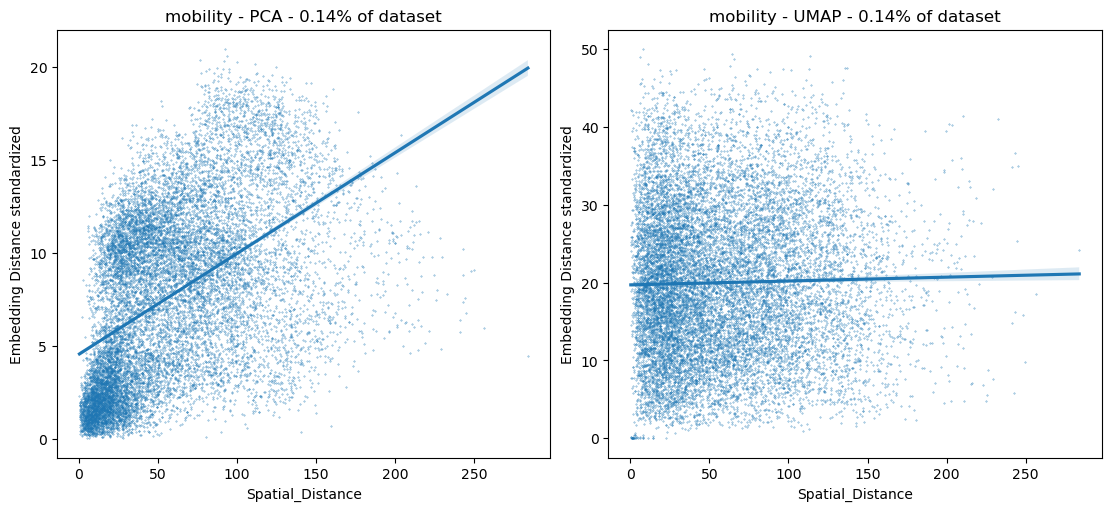

In [74]:
distance = spatial_distance
distance_label = 'Spatial_Distance'
for standardized in ['standardized', 'not standardized']:
    for embedding_name in stages:
        pca_dist_list = embedding_distances_all[standardized][embedding_name]['pca_dist_list']
        umap_dist_list = embedding_distances_all[standardized][embedding_name]['umap_dist_list']

        fig, ax = plt.subplots(1, 2, figsize=(11, 5), constrained_layout=True)

        df_plot = pd.DataFrame(zip(distance, pca_dist_list), columns=['distance', 'pca'])
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_plot['distance'], df_plot['pca'])
        a = sns.regplot(
            ax=ax[0],
            data=df_plot,
            x="distance", y="pca",
            scatter_kws={"s": 0.1},
            line_kws={'label':"y={0:.3f}x+{1:.1f}".format(slope,intercept)}
        )

        a.set_title(f'{embedding_name} - PCA - '+ "{0:.2f}".format(percent) + '% of dataset')
        a.set_xlabel(distance_label)
        a.set_ylabel(f'Embedding Distance {standardized}')
#         a.set_ylim(0, 0.5)

        df_plot = pd.DataFrame(zip(distance, umap_dist_list), columns=['distance', 'umap'])
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_plot['distance'],df_plot['umap'])
        a = sns.regplot(
            ax=ax[1],
            data=df_plot,
            x="distance", y="umap",
            scatter_kws={"s": 0.1},
            line_kws={'label':"y={0:.3f}x+{1:.1f}".format(slope,intercept)}
        )

        a.set_title(f'{embedding_name} - UMAP - '+ "{0:.2f}".format(percent) + '% of dataset')
        a.set_xlabel(distance_label)
        a.set_ylabel(f'Embedding Distance {standardized}')
#         a.set_ylim(0, 48)
#         dirr = root + 'train/outputs/' + scenario + f'scatterplots/{embedding_name}/'
#         if not os.path.exists(dirr):
#             createCleanDir(dirr)

#         plt.savefig(dirr + f'{distance_label}_scatterplot_{standardized}', bbox_inches='tight')

4 subplots of each stage

In [78]:
embedding_distances_all[standardized][embedding_name]

{'pca_dist_list': [0.0646813,
  0.25337,
  0.015916811,
  0.052097786,
  0.12035441,
  0.09710589,
  0.21795751,
  0.031017762,
  0.24196102,
  0.22199284,
  0.34932953,
  0.19748136,
  0.3290588,
  0.12606649,
  0.07731591,
  0.24323379,
  0.15350713,
  0.060734183,
  0.2842705,
  0.2657935,
  0.15862411,
  0.3287918,
  0.20676988,
  0.1992652,
  0.28703398,
  0.020828363,
  0.3055726,
  0.19170286,
  0.2563292,
  0.051242467,
  0.13803637,
  0.19504718,
  0.15000927,
  0.1651542,
  0.25288886,
  0.19558983,
  0.25454906,
  0.239474,
  0.096727714,
  0.24610463,
  0.35057947,
  0.22717926,
  0.0502683,
  0.259528,
  0.19900407,
  0.2562054,
  0.2484619,
  0.2869016,
  0.25321877,
  0.28691632,
  0.20648366,
  0.21186513,
  0.30824077,
  0.19217849,
  0.24247994,
  0.16509892,
  0.32538262,
  0.22745298,
  0.15295784,
  0.30447942,
  0.15599512,
  0.013691575,
  0.29139414,
  0.36459753,
  0.20860249,
  0.18198174,
  0.13151781,
  0.19096573,
  0.0900202,
  0.35938358,
  0.21959534,
  

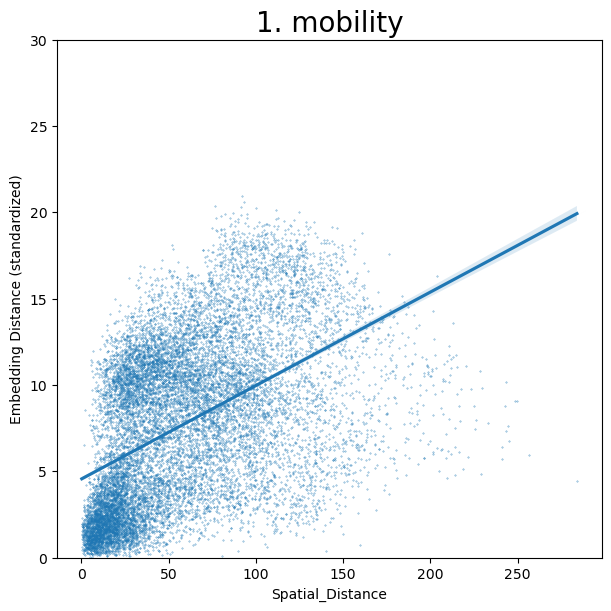

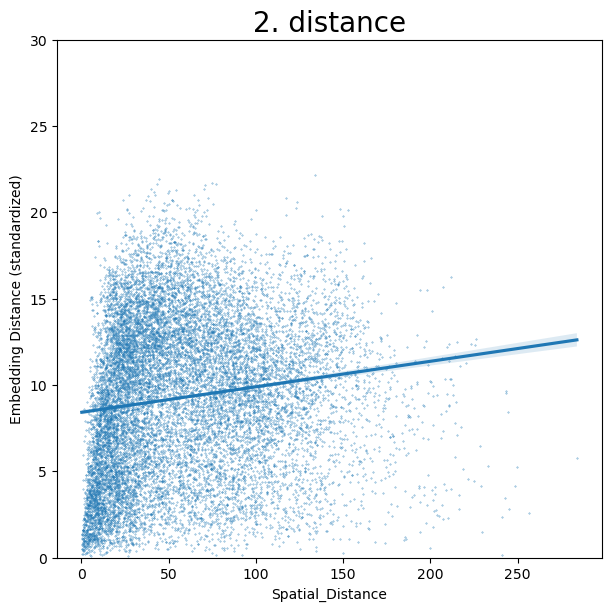

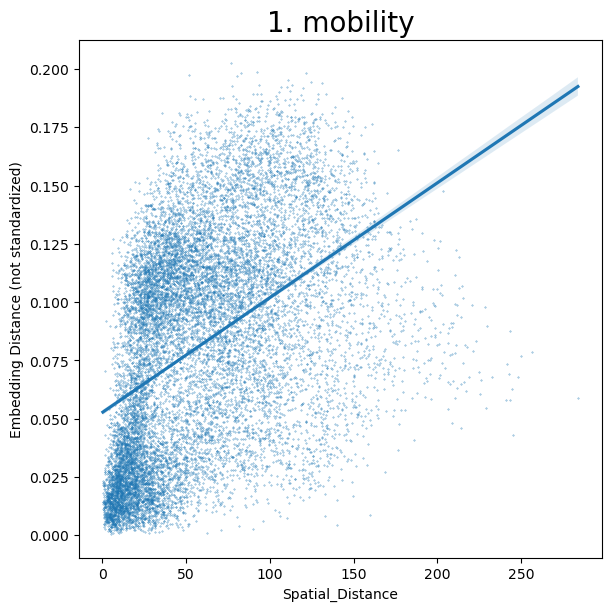

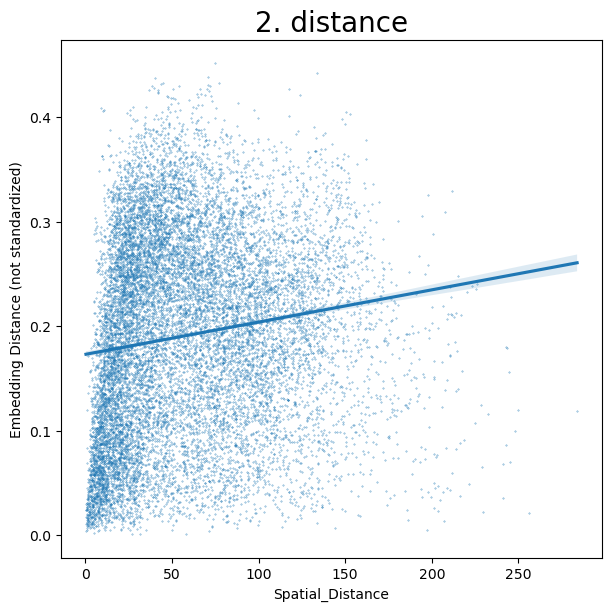

In [79]:
distance = spatial_distance #mobility_
dr = 'pca'
distance_label = 'Spatial_Distance'# 'Spatial_Distance' #'Mobility'
for standardized in ['standardized', 'not standardized']:
#     fig, ax = plt.subplots(2, 2, figsize=(11, 10), constrained_layout=True)
#     axes = ax.flatten()
    for i, embedding_name in enumerate(stages):
        fig, ax = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
        dist_list = embedding_distances_all[standardized][embedding_name][f'{dr}_dist_list']

        df_plot = pd.DataFrame(zip(distance, dist_list), columns=['distance', dr])
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_plot['distance'], df_plot[dr])
        a = sns.regplot(
            ax=ax, #es[0]
            data=df_plot,
            x="distance", y=dr,
            scatter_kws={"s": 0.1},
            line_kws={'label':"y={0:.3f}x+{1:.1f}".format(slope,intercept)}
        )

        a.set_title(f'{i+1}. {embedding_name}', fontsize=20)
        a.set_xlabel(distance_label)  #  
        a.set_ylabel(f'Embedding Distance ({standardized})')
        if standardized == 'standardized':
            a.set_ylim(0, 30)

#     dirr = root + 'train/outputs/' + scenario + f'scatterplots/{distance_label}/'
#     if not os.path.exists(dirr):
#         createCleanDir(dirr)
#     plt.suptitle(f'{dr} - ' + "{0:.2f}".format(percent) + '% of dataset', fontsize=20)
#     plt.savefig(dirr + f'{dr}_scatterplot_{standardized}', bbox_inches='tight')

In [220]:
# df_plot = pd.DataFrame(zip(mobility_distance, pca_dist_list), columns=['distance', 'pca'])
# # slope, intercept, r_value, p_value, std_err = stats.linregress(df_plot['distance'],df_plot['pca'])
# ax = sns.regplot(
#     data=df_plot,
#     x="distance", y="pca",
#     scatter_kws={"s": 0.1},
    
# )
# plt.xscale("log")
# plt.title(f'PCA - '+ "{0:.2f}".format(percent) + '% of dataset')
# plt.xlabel('Mobility')
# plt.ylabel('Embedding Distance')
# plt.ylim(min(pca_dist_list), max(pca_dist_list))
# plt.xlim(min(mobility_distance), 1000)
# # plt.savefig(root + 'train/outputs/' + scenario + 'pca_mobility_scatterplot')

In [221]:
# df_plot = pd.DataFrame(zip(mobility_distance, pca_dist_list), columns=['distance', 'umap'])
# slope, intercept, r_value, p_value, std_err = stats.linregress(df_plot['distance'],df_plot['umap'])

# ax = sns.regplot(
#     data=df_plot,
#     x="distance", y="umap",
#     scatter_kws={"s": 0.1},
    
# )
# plt.xscale("log")
# plt.title(f'UMAP - '+ "{0:.2f}".format(percent) + '% of dataset')
# plt.xlabel('Mobility')
# plt.ylabel('Embedding Distance')
# plt.ylim(min(pca_dist_list), max(pca_dist_list))
# plt.xlim(min(mobility_distance), 5000)

# Vizualization of ResNet extracted features

In [187]:
# # mobility data
# graph_path = root + 'dataset/safegraph/graph_checkpoints/nyc_metro/checkpoint_norm.pkl'
# with open(graph_path, 'rb') as f:
#     g = pickle.load(f)

# ResNet
- Select paired ResNet Embeddings

In [7]:
def get_resnet_embedding(geoid, datasets1, node_list):
    idx = node_list.loc[node_list['GEOID'] == geoid].index.values[0]
    return datasets1.__getsampleembeddingtest__(idx)

In [8]:
earth_engine_filename = 'least_cloudy_m6_m10_rectangle_highres.tif'
# earth_engine_filename = 'least_cloudy_m6_m10_rectangle_fixedlargesize.tif'
fn = earth_engine_filename
data_type = 'landsat'
device='cpu'

# landsat_model = ResNetTransform(device)
pre_trained = root + 'train_cnn_on_remote_sensing/best_trained_model.tar'
checkpoint=torch.load(pre_trained)
landsat_model = RSResNet18()
landsat_model.load_state_dict(checkpoint['model_state_dict'],strict=False)
landsat_model.modify_output_layer(200)
print(landsat_model.model)
landsat_model.model.eval()
    
# scenario='highres_landsat_experiment/'
# node_list_path= root + f'dataset/preprocessed_data/{scenario}node_list.csv'
# datasets_highres = SatelliteImageryDataset(node_list_path=node_list_path, 
#                                     root_image_dir='../dataset/earth_engine/download_landsat_images', 
#                                     fn=fn, is_train=True, transform=landsat_model, 
#                                     load_embeddings=True, embedding_fn='img_resnet_original.pt')
# scenario='lowres_landsat_experiment/'
# node_list_path= root + f'dataset/preprocessed_data/{scenario}node_list.csv'
# datasets_lowres = SatelliteImageryDataset(node_list_path=node_list_path, 
#                                     root_image_dir='../dataset/earth_engine/download_landsat_images', 
#                                     fn=fn, is_train=True, transform=landsat_model, 
#                                     load_embeddings=True, embedding_fn='img_resnet_original.pt')

scenario = 'all_valid_data_finetunedresnet/'
node_list_scenario='all_valid_data/'
node_list_path= root + f'dataset/preprocessed_data/{node_list_scenario}node_list.csv'
datasets_all = SatelliteImageryDataset(node_list_path=node_list_path, 
                                    root_image_dir='../dataset/earth_engine/download_landsat_images', 
                                    fn=fn, is_train=True, transform=landsat_model, 
                                    load_embeddings=True, embedding_fn='resnet_finetuned.pt') #'img_resnet_original.pt'

/home/julia/miniconda3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/julia/miniconda3/envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer is modified
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReL

In [ ]:
datasets_all

In [9]:
# generate random indices

pca=PCA(n_components=2)
umap_reducer = umap.UMAP(n_neighbors=30, min_dist=0, n_components=2, metric='euclidean', random_state=42)
geoids_list = []
# #  get resnet embeddings from model
# node_list = datasets_highres.node_list
# geoids = list(node_list.GEOID)
# geoids_list.extend(geoids)
# embeddings_1 = np.array([get_resnet_embedding(geoid, datasets_highres, node_list) for geoid in geoids])

# node_list = datasets_lowres.node_list
# geoids = list(node_list.GEOID)
# geoids_list.extend(geoids)
# embeddings_2 = np.array([get_resnet_embedding(geoid, datasets_lowres, node_list) for geoid in geoids])

# node_list = [i for i in datasets_all.node_list.GEOID if 
#              (i not in datasets_highres.node_list.GEOID and i not in datasets_lowres.node_list.GEOID)]
node_list = [i for i in datasets_all.node_list.GEOID]
geoids = node_list
geoids_list.extend(geoids)
embeddings_3 = np.array([get_resnet_embedding(geoid, datasets_all, datasets_all.node_list) for geoid in geoids])

# ResNet Clustering

In [10]:
# Standardized
ss = StandardScaler()
# df1 = pd.DataFrame(ss.fit_transform(embeddings_1))
# df2 = pd.DataFrame(ss.fit_transform(embeddings_2))
df3 = pd.DataFrame(ss.fit_transform(embeddings_3))
df = df3

In [18]:
# # Standardized
# df1['Label'] = 'High Resolution'
# df2['Label'] = 'Low Resolution'
# df3['Label'] = 'Middle 50%'

# # Unstandardized
# df1 = pd.DataFrame(embeddings_compare[:,0,:])
# df1['Label'] = 'High Resolution'

# df2 = pd.DataFrame(embeddings_compare[:,1,:])
# df2['Label'] = 'Low Resolution (Downsampled)'

In [11]:
# df = df1.append(df2).append(df3)
df['GEOID'] = geoids_list

In [12]:
# alldf = df.copy()
# df = df.loc[df.Label.isin(['High Resolution', 'Low Resolution'])]

In [13]:
binned_geoid = pd.read_csv(root + 'dataset/earth_engine/landsat_resolution_binned_geoids.csv', dtype={'GEOID': str})
df = df.merge(binned_geoid, on='GEOID')
df.head()

0         1         2         3         4         5         6  \
0 -0.723874 -1.397541 -0.965246 -1.454729 -1.692385 -0.504503 -0.025169   
1  0.134992  1.223253  0.990331  0.626814  0.942153 -0.100312  0.317541   
2  0.082015  1.118329  0.999062  0.938961  0.592374 -0.505882  0.258892   
3  0.506424  1.030120  1.062402 -0.189179  0.382521  0.209423  0.505368   
4 -0.703193  0.811363 -1.088981  1.171355 -0.627651 -2.197746  1.910317   

          7         8         9  ...       193       194       195       196  \
0  0.453241  0.423120  1.052995  ... -0.522578 -0.697993 -0.457746 -0.941220   
1 -1.283480  0.327726 -0.001597  ... -0.578941 -0.427661 -0.945033  1.110916   
2 -1.476780  0.442999  0.354936  ... -0.954384  0.324954 -1.079569  0.855299   
3 -0.290909 -0.334961 -0.105101  ... -0.672352 -1.004755 -0.940328  0.793286   
4  0.730186 -1.051027 -1.867159  ... -1.526388 -2.114398  0.698089 -0.801048   

        197       198       199        GEOID  npixels  pixel_bin  
0  0.146265  0.056500 -0.641822  09009350400      928          1  
1 -0.367263 -0.090264  0.384685  09009352701    11026          3  
2 -0.343658 -0.642850  0.027425  09009352702     6325          2  
3 -0.427076  1.284616  0.448570  09009352800    17500          3  
4  1.589748 -0.701463  1.553986  09009166002    56163          3  

[5 rows x 203 columns]

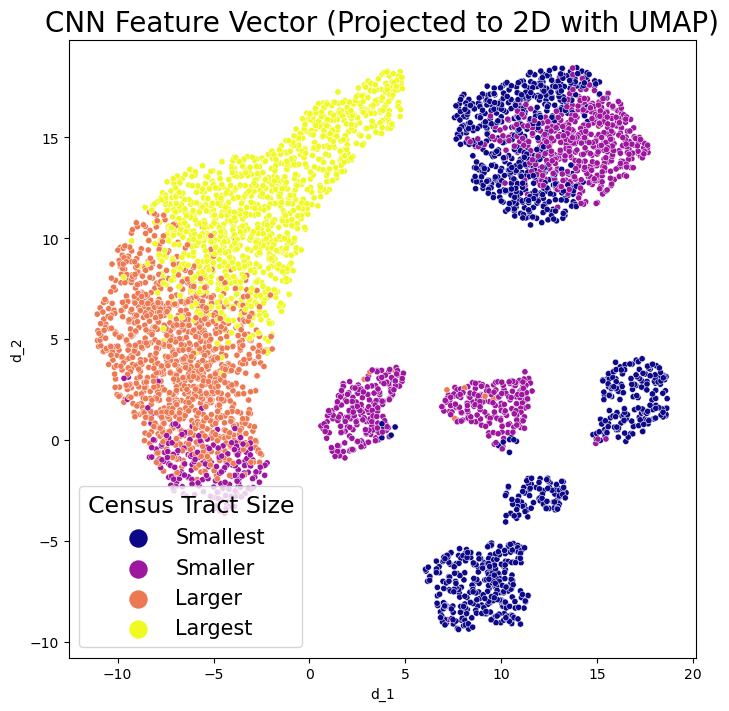

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7), constrained_layout=True)
col='pixel_bin' #'pixel_bin' #'npixels'#'Label' 'pixel_bin'
reducer = umap.UMAP(n_neighbors=30, min_dist=1, n_components=2, metric='euclidean', random_state=42)
# reducer=PCA(n_components=2)
Y = reducer.fit_transform(df[[i for i in range(0, 200)]])

result_df = pd.DataFrame({'d_1': Y[:,0], 'd_2': Y[:,1], col: df[col]})

#### For plotting all variables on same figure #####
# axis = ax[0]
sns.scatterplot(x='d_1', y='d_2', hue=col, data=result_df, 
                ax=ax, s=20, palette=plt.colormaps['plasma'])
ax.set_title(f'CNN Feature Vector (Projected to 2D with UMAP)', fontsize=20)
ax.axis("tight")

handles, labels  =  ax.get_legend_handles_labels()
l = ax.legend(title='Census Tract Size', handles=handles, labels=['Smallest', 'Smaller', 'Larger', 'Largest'],
         fontsize=15, title_fontsize=17)
l.legend_handles[0]._sizes = [150] 
l.legend_handles[1]._sizes = [150] 
l.legend_handles[2]._sizes = [150] 
l.legend_handles[3]._sizes = [150] 

savedir=root +  f'train/outputs/{scenario}evaluate/'
# plt.savefig(savedir + f'umap_compare_highlowres_ResNetfeatures_npixels', bbox_inches='tight')
plt.show()